<center>

<img src='./img/sber.jpg' width='500'>

# Анализ временных рядов на примере прогнозирования спроса наличности в банкоматах
</center>

**Авторы материала:** Денис Димитров, Марк Потанин, Алексей Рябых, Мария Тихонова. Материал можно использовать в любых целях (редактировать, поправлять и брать за основу), но с обязательным упоминанием авторов материала.

## <center>Часть 2. Специфика работы с реальными данными на примере спроса наличности в банкоматах</center>

# План:

1. Предобработка данных
    - Некоторые примеры реальных временных рядов, с которыми приходится работать
    - Формируем пул хороших историй
    - Учимся заменять недлительные простои
    - Заменяем длительные простои у "плохих" банкоматов
2. AnomalyDetector (на основе CUSUM)
    - Немного теории...
    - Пример работы, выявляем зарплатные пики
3. Прогноз
    - Формируем признаковое пространство
    - Строим прогноз

## 1. Предобработка данных

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from math import *
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [2]:
from FullPackPrediction import *

### 1.1. Пока что просто посмотрим на данные, которые мы можем использовать

In [3]:
target_col = 'CLIENT_OUT'

# Читаем историю снятий
smsb = pd.read_csv('./data/lecture2/atm_data_train.csv', index_col=0, parse_dates=True).rename(columns = {'Клиентский расход' : target_col})
smsb.head()

,ATM_ID,Входящий остаток,CLIENT_OUT
2015-01-01,869273,6782200.0,0.0
2015-01-01,785116,8104000.0,0.0
2015-01-01,786314,11700600.0,274800.0
2015-01-01,786676,9891200.0,0.0
2015-01-01,791711,4698800.0,10000.0


In [4]:
# Информация о времени доступности
df_availability = pd.read_csv('./data/lecture2/df_availability.csv', index_col = 0)
df_availability.head()

,name_opti,CASHP_ID,1,2,3,4,5,6,7,24 h
ATM_ID,,,,,,,,,,
35426,ATM35426,ATM03062,1,1,1,1,1,0,0,0.0
36008,ATM36008,ATM03053,1,1,1,1,1,1,1,0.0
36009,ATM36009,ATM03017,1,1,1,1,1,0,0,0.0
36010,ATM36010,ATM03063,1,1,1,1,1,0,0,0.0
36413,ATM36413,ATM03100,1,1,1,1,1,1,1,0.0


In [5]:
# Кластеризация банкоматов по типу размещения (поле cluster)
# Также в таблице содержится дополнительная информация о геолокации устройств (адресс, координаты)
df_places = pd.read_csv('./data/lecture2/df_places.csv', index_col = 0)
df_places.head()

,ADDRESS,ADDR_ADDON,DEPT1_ID,LATITUDE,LONGITUDE,OPENDATE,ATM_ID,type,zone,expense,cluster
0,"ул Никулинская, 25",ВСП 7970/1751,KU1_UIATM,55.669628,37.453171,2009-12-23 00:00:00,34074,ATM,3.0,1905.345101,0
1,"ул Никулинская, 25",ВСП 7970/1751,KU1_UIATM,55.669628,37.453171,2009-12-23 00:00:00,34084,ATM,3.0,1905.345101,0
2,"ул Никулинская, 25",ВСП 7970/1751,KU1_UIATM,55.669628,37.453171,2009-12-23 00:00:00,34100,ATM,3.0,1905.345101,0
3,"ул СОВЕТСКОЙ АРМИИ, 17/52",ВСП 7981/26,KU4_UIATM,55.792767,37.614964,2008-08-05 00:00:00,34401,ATM,1.0,1836.226679,0
4,"ул Милашенкова, 4","ТЦ ""Матрица""",KU4_UIATM,55.823715,37.590939,2008-08-05 00:00:00,34724,ATM,3.0,1905.345101,2


In [6]:
#Расшифровку кластеров можно найти в следующем файле.
clusters = pd.read_csv('./data/lecture2/clusters.csv', index_col = 'cluster_number')
clusters

,cluster_name
cluster_number,
0,bank
1,small_shop
2,big_shop
3,transport
4,hospital
5,metro
6,park
7,culture
8,education_building


Иногда по техническим причинам банкоматы перестают выдавать наличность (_что-то сломалось/закончились деньги в кассете итд_). В этом случае исторические значения временного ряда не отражают реальный клиентский спрос; такие значения являются аномальными для модели, поскольку эта модель должна работать в преположении, что в будущем поломок не будет. Время, в течение которого банкомат не функционировал по техническим причинам, в дальнейшем будем называть **простоем**.

Таблица ниже содержит информацию о простоях, которая записана в следующем виде: для каждой даты, для каждого устройства - **ATM_ID** - в поле **downtime** записана доля времени (от общего времени работы банкомата), в течение которого банкомат не функционировал по техническим причинам.

In [7]:
# Информация о простоях банкоматов: для каждого банкомата известен процент времени, в течении которого банкомат
# по техническим причинам не выдавал деньги
downtime = pd.read_csv('./data/lecture2/downtimes_opt.csv', index_col = 'Unnamed: 0', parse_dates = True)
downtime

,ATM_ID,downtime
2015-01-01,869273,0.0
2015-01-02,869273,0.0
2015-01-03,869273,0.0
2015-01-04,869273,0.0
2015-01-05,869273,0.0
...,...,...
2017-09-13,381600,0.0
2017-09-14,381600,0.0
2017-09-15,381600,0.0
2017-09-16,381600,0.0


Для корректной работы модели необходимо учитывать недельную сезонность (с учетом праздников, переносом выходных дней и прочее). Данную информацию можно получить из производственного календаря.

Ниже подгружается таблица, содержащая необходимые данные о производственном календаре.

In [8]:
# Информация о производственном календаре
events = pd.read_csv('./data/lecture2/events.csv', index_col=0, parse_dates=True)
events.head()

,выходной,праздник,короткий рабочий день,предпраздничный рабочий день,предвыходной рабочий день,последний день месяца,пн,вт,ср,чт,...,сентябрь,октябрь,ноябрь,декабрь,27-Дек,28-Дек,29-Дек,30-Дек,31-Дек,предвыходной
2009-01-01,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0
2009-01-02,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0
2009-01-03,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0
2009-01-04,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0
2009-01-05,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0


### 1.2. Теперь разберем игрушечный пример, который показывает, как можно искать похожие банкоматы в заданном наперед пуле банкоматов (то есть историй спроса наличности в этих банкоматах)

Оставляем множество тех банкоматов $A$, с которым мы хотим работать (в реальности - это множество историй оборота наличности во всех изучаемых банкоматах - достаточно большое множество, и вообще говоря, полный файлик _smsb_). В дальнейшем оно будет разделено на два пула: пул хороших историй $G$, которые будут использованы для **возможных** замен истории, и пул плохих историй $B$, содержащих большое количество простоев, участки которых **точно** будут заменяться на участки историй из первого хорошего пула.

В связи с этим, чем больше будет общий пул $A$ (а в частности, $G$), тем более точно будет подбираться история для замены плохим банкоматам из пула $B$, поскольку будет больше возможность выбора. Можно сказать даже больше: для того, чтобы в пуле хороших историй $G$ удалось найти похожий банкомат для какого-то банкомата с плохой историей, он (а значит и исходное множество банкоматов - $A$) должен быть достаточно большим. В противном случае качество подобранной истории и, как следствее, качество прогнозирования может упасть.

Ниже по коду множество $A$ определим вручную (у нас же игрушечный пример) - оно будет состоять всего из $18$ банкоматов. Обозначим его **subpool**.

In [9]:
#Оставляем только нужные id

subpool = [869273, 785116, 786314,  791711, 791712, 794249,  794288, 794289, 794989, 
           785115, 794992, 796427, 796428, 797235, 798092, 798105, 801061, 801096]


def select_from_subpool(smsb, df_places, df_availability, downtime, subpool):
    smsb = smsb[smsb.ATM_ID.isin(subpool)]
    df_places = df_places[df_places.ATM_ID.isin(subpool)]
    df_availability = df_availability[df_availability.index.isin(subpool)]
    downtime = downtime[downtime.ATM_ID.isin(subpool)]
    return smsb, df_places, df_availability, downtime

smsb, df_places, df_availability, downtime = select_from_subpool(smsb, df_places, df_availability, downtime, subpool)
print('Total number of ATMS: ', len(smsb.ATM_ID.unique()))

Total number of ATMS:  18


На этапе ниже определяется, какие банкоматы попадут из $A$ в **пул хороших историй** $G$. 

**Определение.** Историю банкомата будем называть **хорошей**, если она удовлетворяет следующим критериям:

   * доля дней, когда у банкомата был сколько-нибудь продолжительный простой в течение дня ($downtime > 0$) менее $5$%
   * все длительные простои банкомата менее 14 дней подряд
   
Если банкомат не удовлетворяет хотя бы одному из этих критириев, то его историю будем называть **плохой**.

**Проблема**: почему были взяты именно такие точки отсечения ($5$% и $14$ дней)? На самом деле, просто так. Это некоторые априорные наблюдения за банкоматами Сбербанка в течение длительного времени.

Возможно надо применять некоторые адаптивные правила и заменять экспертное правило.

In [10]:
## Данная функция преобразует информацию о простоях банкомата в удобный вид.
## Вход:
##   timeseries_downtimes - ряд с информацией о простоях (для каждого дня записана доля 
##                          времени в течении которого банкомат простаивал)
##   downtime_threshold -   длина простоя, порог
## Выход:
##   downtime_df - DataFrame, содержащий информацию о простоях 
##                 длительностью более downtime_threshold. 
##                 Таблица содержит две колонки 'downtime_begin' и 'downtime_end'.
##                 В каждой строке записана дата начала и конца простоя.

def detect_downtimes(timeseries_downtimes, 
                     downtime_threshold=14):

    begin_dates = []
    end_dates = []

    series_mask = 1.0 * (timeseries_downtimes > 0)
    count = 0

    for ind in series_mask.index:
        if count >= downtime_threshold and series_mask[ind] == 0:
            end_dates.append(ind - pd.Timedelta('1 days'))
            begin_dates.append(ind - pd.Timedelta(str(count) + ' days'))
        count = (count + 1) * series_mask[ind]

    if count >= downtime_threshold:
        end_dates.append(ind)
        begin_dates.append(ind - pd.Timedelta(str(count - 1) + ' days'))

    downtime_df = pd.DataFrame(np.array([begin_dates, end_dates]).T, columns=['downtime_begin', 'downtime_end'])
    return downtime_df

In [11]:
detect_downtimes(smsb[smsb.ATM_ID == 869273]['CLIENT_OUT'], 10)

,downtime_begin,downtime_end
0,2015-04-20,2015-04-30


Ниже производится отбор хороших историй (удовлетворяющих соответствующим критериям), которые затем попадут в пул хороших историй.

**Важно!** На данном этапе сам пул еще НЕ формируется, а лишь отбираются номера устройств (**ATM_ID**), сам пул формируется позднее, когда истории пройдут дополнительную обработку.

In [12]:
# Отбираем id (из subpool), которые затем попадут в пул ХФИ

def create_good_id_pool(downtime):
    # Для каждого банкомата считаем долю простоев (Crime)
    for_hist = []
    for i in downtime.ATM_ID.unique():
        # crime - доля дней для конкретного банкомата, когда были хоть какие-то простои
        for_hist.append((i,(1.0 *(downtime[downtime.ATM_ID == i]['downtime'] > 0)).sum()/len(downtime[downtime.ATM_ID == i])))
    for_hist_df = pd.DataFrame(for_hist)
    for_hist_df.columns = ['ID', 'Crime']

    good = []
    # В случае, когда доля простоев не превосходит 5%
    for i in for_hist_df[for_hist_df['Crime'] < 0.05]['ID']: 
        # и нет простоев длинее 14 дней
        if len(detect_downtimes(downtime[downtime.ATM_ID == i]['downtime'], 14)) == 0:
            # id банкомата будет называть хорошим
            good.append(i)

    pool_ids = list(set(good))
    return pool_ids
                    
pool_ids = create_good_id_pool(downtime)
print('Number of good histories: ', len(pool_ids))
print('Good histories: ', pool_ids)

Number of good histories:  9
Good histories:  [801061, 786314, 796427, 796428, 794989, 794992, 797235, 785115, 785116]


#### Создание пула Хороших историй
Для каждой хорошей истории, отобранной на предыдущем шаге, производится обработка: недлительные простои и аномалии заменяются предсказаниями.

In [13]:
## Функция по обработке одной истории с уже подготовленным признаковым пространством (predictor)
## Вход:
##   timeseries           - ряд с информацией о снятиях
##   timeseries_downtimes - ряд с информацией о простоях (для каждого дня записана доля 
##                          времени в течении которого банкомат простаивал)
## Выход:
##   processed_timeSeries - обработанный ряд с информацией о снятиях

def process_history(timeSeries, timeSeries_downtimes, predictor):
    changer = Changer(ID=None,timeseries=None, timeseries_downtime=None, pool=None)
    downtime_periods = detect_downtimes(timeSeries_downtimes, 1)
    processed_timeSeries = timeSeries.copy()
    

    for index in downtime_periods.index:
        if (downtime_periods.downtime_begin[index] - timeSeries.index[0]).days > 30:
            if (downtime_periods.downtime_begin[index] - timeSeries.index[0]).days < 365: 
                predictor.is_mean_month = None
            else:
                predictor.is_mean_month = True
            horizon = (downtime_periods.downtime_end[index] - downtime_periods.downtime_begin[index]).days + 1
            pred = predictor.realtime(time_series=processed_timeSeries[:downtime_periods.downtime_begin[index] - pd.Timedelta('1 days')],
                                      re_fit = None, horizon=horizon) 

            processed_timeSeries[pred.index] = pred
    return processed_timeSeries

## Функция по подготовке признакового пространства (predictor) для последующей обработки
## в функции process_history
## Вход:
##   timeseries           - ряд с информацией о снятиях
##   timeseries_downtimes - ряд с информацией о простоях (для каждого дня записана доля 
##                          времени в течении которого банкомат простаивал)
##   events               - признаковое пространство, полеченное из производственного календаря
##   target_col           - название целевой переменной (ДАННОЕ ЗНАЧЕНИЕ по УМОЛЧАНИЮ ЛУЧШЕ НЕ МЕНЯТЬ!!!)
## Выход:
##   processed_timeSeries - обработанный ряд с информацией о снятиях

def create_good_history_ATM(timeSeries, timeSeries_downtime, events, target_col = 'CLIENT_OUT'):        
    # Создание зарплатных фичей
    salary = Salary(timeseries=timeSeries, threshold=0.15)
    feature = salary.get_features()
    
    # Объединение зарплатных фичей и признаков из производственного календаря
    events_sal = pd.concat([events, feature], axis=1, join='inner')
    
    # Создание Predictor с необходимым признаковым пространством
    predictor = Predictor(calendar_features=events_sal)
    
    # Обработка истории
    processed_timeSeries = process_history(timeSeries, timeSeries_downtime, predictor)
       
    return processed_timeSeries

Ниже для каждого хорошего банкмата в цикле запускается обработка истории (см. блок выше). Таким образом, формируется пул хороших историй $G$ или **pool_processed**.

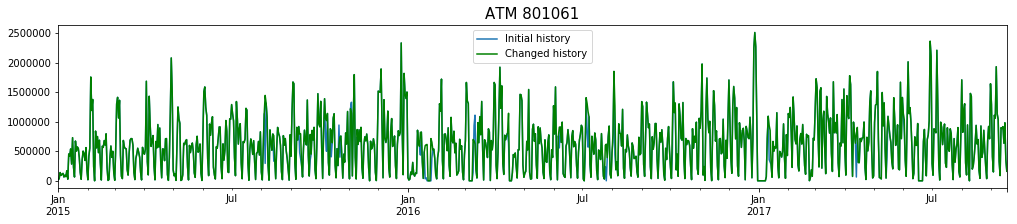

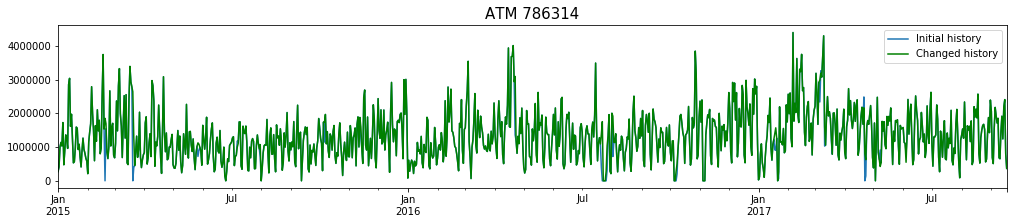

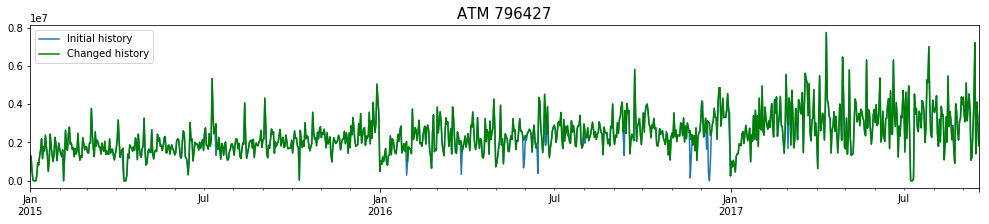

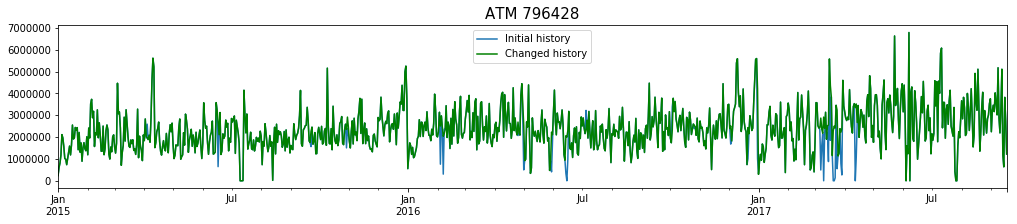

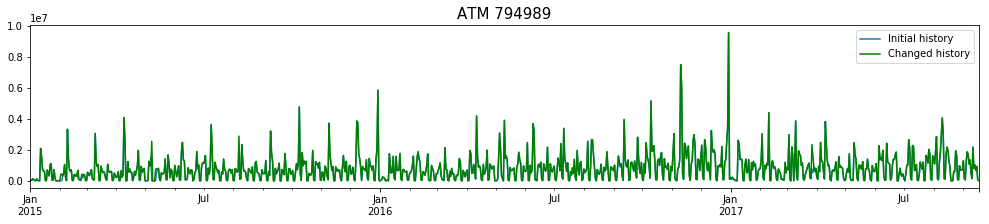

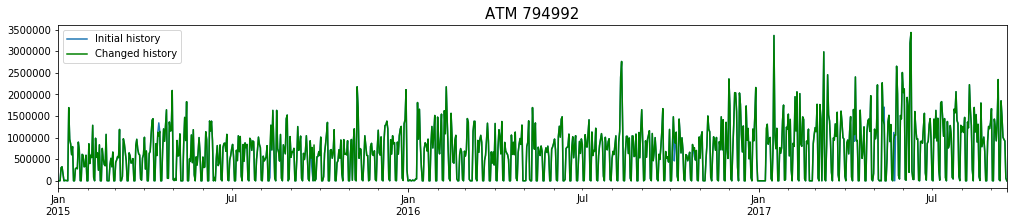

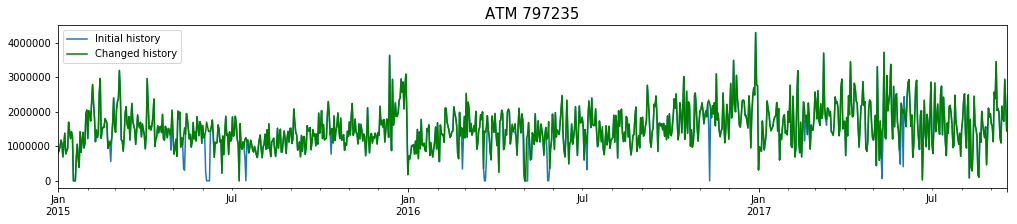

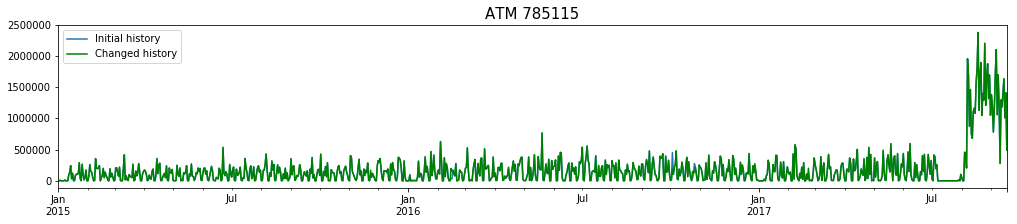

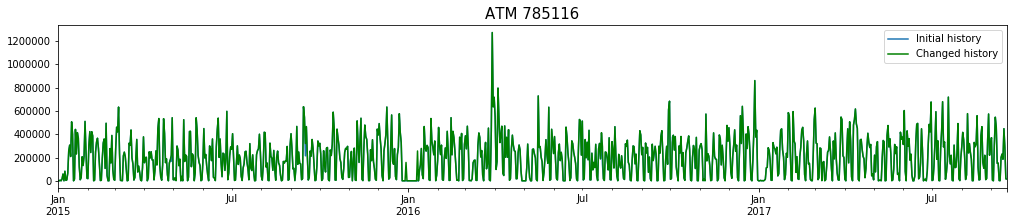

In [14]:
# Обрабатываем отобранные хорошие истории для подготовки пула хороших историй
pool_processed = pd.DataFrame()

#Цикл по банкоматам для формирования пула хороших историй
for ID in pool_ids:
    # Информация о временном ряде
    timeSeries = smsb[smsb.ATM_ID == ID][target_col].copy()
    
    # Рисуем ряд
    timeSeries.plot(figsize = (17, 3), label = 'Initial history')
    
    # Информация о простоях
    timeSeries_downtime = downtime[downtime.ATM_ID == ID].downtime
    
    #  Сама обработка (самая важная строчка)
    processed_timeSeries = create_good_history_ATM(timeSeries, timeSeries_downtime, events, target_col = 'CLIENT_OUT')
    
    # Записываем данные в удобном виде
    processed_timeSeries = pd.DataFrame(processed_timeSeries, columns = [target_col])
    processed_timeSeries['ATM_ID'] = [ID for i in range(len(processed_timeSeries))]
    processed_timeSeries = processed_timeSeries[['ATM_ID', target_col]]
    
    # Рисуем обработанный временной ряд
    processed_timeSeries[target_col].plot(figsize = (17, 3), label = 'Changed history', color = 'green')
    plt.title('ATM '+ str(ID), size = 15)
    plt.legend()
    plt.show()
    
    # Добавляем временной ряд в пул хороших историй
    pool_processed = pd.concat([pool_processed, processed_timeSeries])

В случае работы с хорошими историями заменяются лишь отдельные значения временного ряда. Это объяснимо: на данном этапе происходит обработка временных рядов, у которых процент простоев и аномалий незначительный.

#### Предобработка отавшихся временных рядов.

Напомним, что история была отнесена к **плохим**, если доля простоев во временном ряду $\geq 5$% ИЛИ есть подряд идущие простои длиной $\geq 14$ дней.

Для плохих историй производится следующая обработка:
  * если есть простои $\geq 14$ дней, то вся история банкомата до окончания последнего из длительных простоев заменяется историей банкомата из пула хороших историй (**pool_processed**). При этом история банкомата для замены подбирается наиболее похожей по своим характеристикам.
  * Недлительные простои длиной менее 14 дней заменяются предсказаниями.

## Алгоритм подбора истории 
### для банкомата, имеющего длительный простой ($\geq 14$ дней)

Подбор истории для банкомата сожержащий длительные простои осуществляется следующим образом:

 * Для банкомата определяется конец последнего длительного простоя $\textit{end_date}$
 * Вся история до этого момента (до $\textit{end_date}$) удаляется и остается только часть от $\textit{end_date}$ до текущего момента $\textit{cur_date}$
 * Все история из пула хороших историй - потенциальные кандидаты для замены - упорядычиваются по убыванию "похожести" их временного ряда на рассматриваемый на участке $(\textit{end_date}$, $\textit{cur_date})$. В алгоритме предусмотрено два режима для вычисления похожести: по корреляции (по умолчанию) и с помощью взаимной информации
 * Затем из множества упорядоченных кандидатов происходит удаление банкоматов, которые не подходят по определенным критериям:
 
     1) **тип размещения** - остаются только банкоматы, которые лежат в том же кластере, что и исходный
     
     2) **время доступности** - остаются только банкоматы с таким же временем доступности
     
     3) **геолокация** - остаются только банкоматы, которые располагаются в пределах трех километров от исходного

При этом, если при применении одного из критериев множество упорядоченных кандидатов становится пустым, то данный критерий не применяется.

 * Из оставшихся рядов (т. е. отфильтрованного по критериям множества упорядоченных кандидатов) выбирается лучшая история. Поскольку мы уже упорядочили все ряды, то лучшей оказывается первая история.
 
 * Весь период до момента окончания последнего длительного простоя заменяется лучшей историей
 
Таким образом, мы получили новую историю для плохого банкомата: до момента окончания последнего длительного простоя она совпадает с одной из историй из пула хороших историй, а после - реальная история интересующего нас банкомата. Для полноты обработки, недлительные простои после окончания простоя, как и в случае с хорошими историями, заменяются предсказаниями.

In [15]:
# обработка истории одного банкомата из общего пула

def create_history_changed_ATM(ID, timeSeries, timeSeries_downtime, pool_processed, df_places, \
                               df_availability, events, target_col = 'CLIENT_OUT'):
    salary = Salary(timeseries=timeSeries, threshold=0.15)
    feature = salary.get_features()
    events_sal = pd.concat([events, feature], axis=1, join='inner')
    predictor = Predictor(calendar_features=events_sal)
    # Замена недлительных простоев предсказаниями
    timeSeries = process_history(timeSeries, timeSeries_downtime, predictor)
    
    changer = Changer(ID=ID, 
                      timeseries=timeSeries, 
                      timeseries_downtime=timeSeries_downtime, 
                      pool=pool_processed, 
                      df_cluster=df_places,
                      df_availability=df_availability,
                      df_address=df_places, 
                      kind='Mutual Information')
    try:
        # Подбор фиктивной истории

        scaled_parts, _ = changer.change_history()
        processed_timeSeries = pd.DataFrame(scaled_parts[0].append(timeSeries[scaled_parts[0].index[-1] + pd.Timedelta('1 days'):]), columns = [target_col])
    
    except:
        scaled_parts = None
        timeSeries.name = None
        processed_timeSeries = pd.DataFrame(timeSeries, columns = [target_col])
        
    return processed_timeSeries

In [16]:
# Пул плохих историй
set(subpool)-set(pool_processed.ATM_ID)

{791711, 791712, 794249, 794288, 794289, 798092, 798105, 801096, 869273}

Возьмем банкомат из пула плохих историй с длительным простоем и проведем для него предобработку.

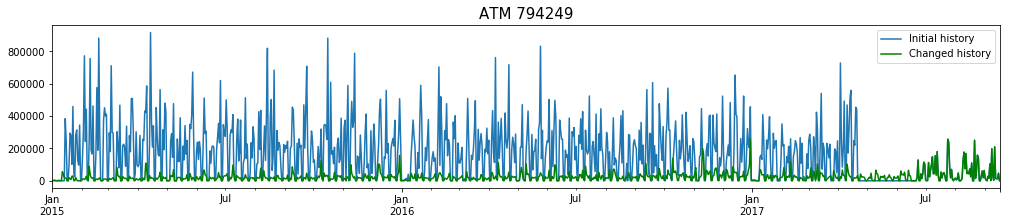

In [17]:
ID = 794249
# Информация о временном ряде
timeSeries = smsb[smsb.ATM_ID == ID][target_col].copy()

# Рисуем ряд
timeSeries.plot(figsize = (17, 3), label = 'Initial history')

# Информация о простоях
timeSeries_downtime = downtime[downtime.ATM_ID == ID].downtime

#  Сама обработка (самая важная строчка)
processed_timeSeries = create_history_changed_ATM(ID, timeSeries, timeSeries_downtime, pool_processed, \
                                                  df_places, df_availability, events, target_col = 'CLIENT_OUT')

# Записываем данные в удобном виде
processed_timeSeries['ATM_ID'] = [ID for i in range(len(processed_timeSeries))]
processed_timeSeries = processed_timeSeries[['ATM_ID', target_col]]

# Рисуем обработанный временной ряд
processed_timeSeries[target_col].plot(figsize = (17, 3), label = 'Changed history', color = 'green')
plt.title('ATM '+ str(ID), size = 15)
plt.legend()
plt.show()

### Про взаимную информацию (mutual information)

Пусть $(\Omega, \mathcal{F}, \sf{P})$ - вероятностное пространство.

$X$ - случайный вектор (со значениями в $\mathbb{R}^d$), $f(\cdot)$ - его плотность относительно меры Лебега в $\mathbb{R}^d$.

Дифференциальная энтропия Шеннона определяется следующим образом ($0 \cdot \log{0} := 0$ по непрерывности):

$H(X) = -\int_{\mathbb{R}^d} f(x) \log{f(x)} \, dx$

Для двух векторов $X$ и $Y$ со значениями в $\mathbb{R}^d$ можно определить взаимную информацию следующим образом:
 
$I(X,Y) := H(X) + H(Y) - H((X,Y))$


**Важная теорема:**

**Всегда $I(X,Y) \geq 0$; при этом $I(X,Y) = 0$ тогда и только тогда, когда  $X, Y$ - независимые**

Доказать это легко, если представить взаимную информацию в виде дивергенции Кульбака-Лейблера:

$I(X, Y) = D (    P_{X,Y}   ||  P_X \times P_Y    )$, где $D(P_{X_1} || P_{X_2}) = \int_{\mathbb{R}^d} \log{\frac{f(x)}{g(x)}} f(x) \ dx$ - дивергенция Кульбака-Лейблера, $P_{X_1}$ имеет плотность $f(x)$, $P_{X_2}$ имеет плотность $g(x)$ (если интеграл неопределен или не является конечным, полагают по непрерывности $D(P_{X_1} || P_{X_2}) = +\infty$).

Кроме того, взаимная информация измеряет не только линейную зависимость между $X$, $Y$, что (в совокупности со свойством из **важной теоремы**) дает взаимной информации преимущество перед корреляцией (ковариацией).

Подробнее про статистическое оценивание энтропии Шеннона/дивергенции Кульбака-Лейблера/взаимной информации по выборке/двум выборкам/двум выборкам соответственно можно прочитать в статье:
https://arxiv.org/pdf/1907.00196.pdf

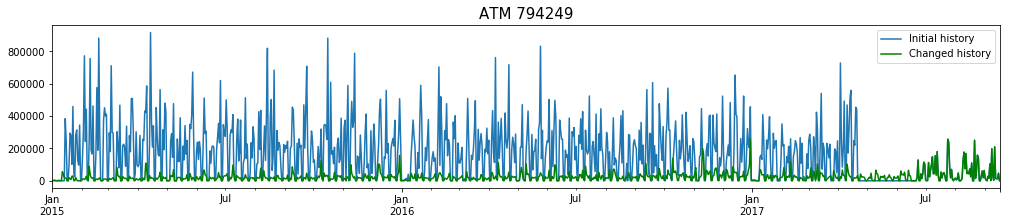

In [18]:
ID = 794249
# Информация о временном ряде
timeSeries = smsb[smsb.ATM_ID == ID][target_col].copy()

# Рисуем ряд
timeSeries.plot(figsize = (17, 3), label = 'Initial history')

# Информация о простоях
timeSeries_downtime = downtime[downtime.ATM_ID == ID].downtime

#  Сама обработка (самая важная строчка)
processed_timeSeries = create_history_changed_ATM(ID, timeSeries, timeSeries_downtime, pool_processed, \
                                                  df_places, df_availability, events, target_col = 'CLIENT_OUT')

# Записываем данные в удобном виде
processed_timeSeries['ATM_ID'] = [ID for i in range(len(processed_timeSeries))]
processed_timeSeries = processed_timeSeries[['ATM_ID', target_col]]

# Рисуем обработанный временной ряд
processed_timeSeries[target_col].plot(figsize = (17, 3), label = 'Changed history', color = 'green')
plt.title('ATM '+ str(ID), size = 15)
plt.legend()
plt.show()

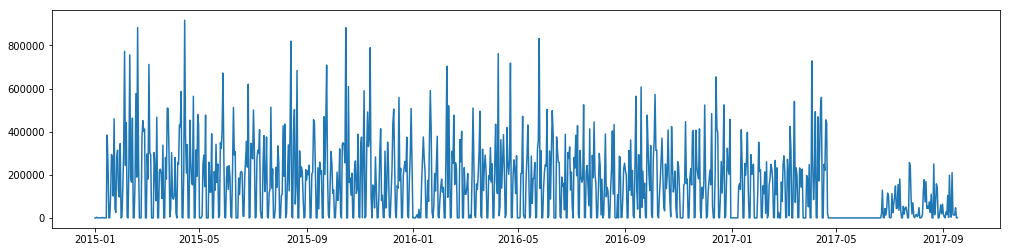

In [19]:
plt.figure(figsize=(17,4))
plt.plot(smsb[smsb.ATM_ID==794249]['CLIENT_OUT'])
plt.show()

Аналогичная обработка для всех банкоматов из пула плохих историй.

791712


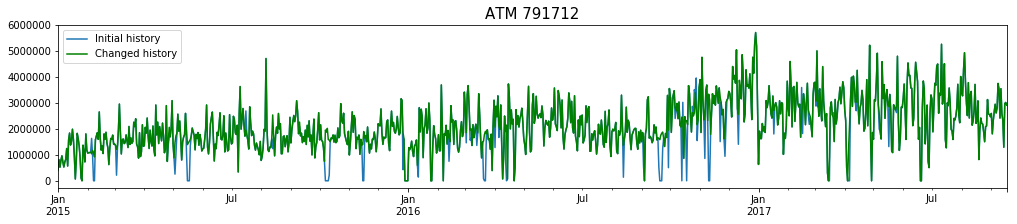

801096


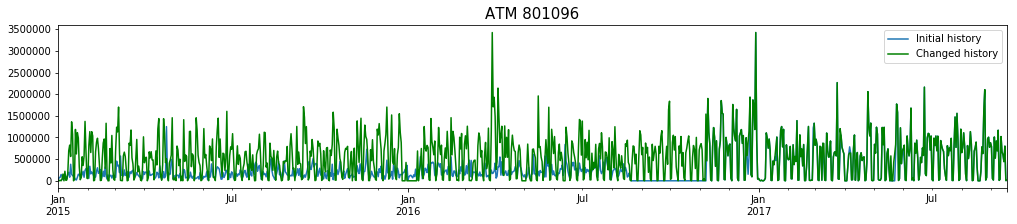

794249


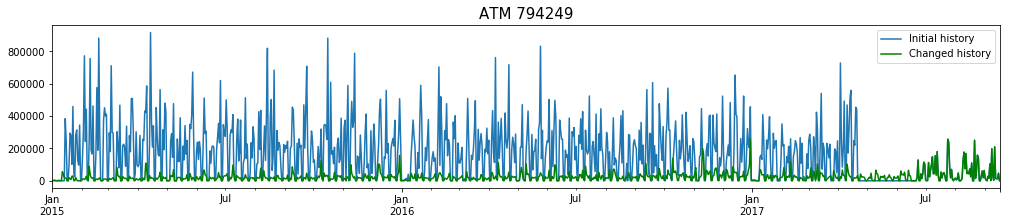

798092


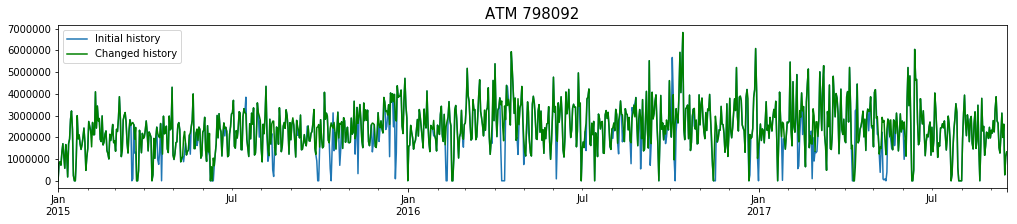

794288


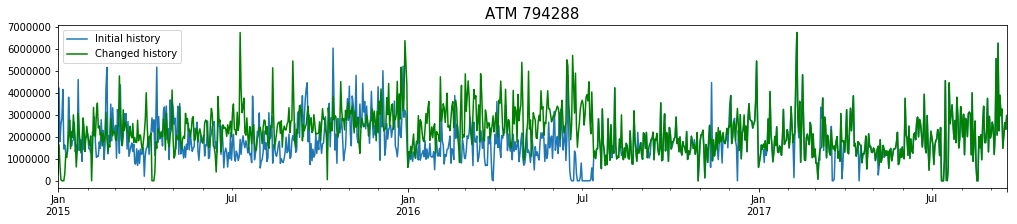

794289


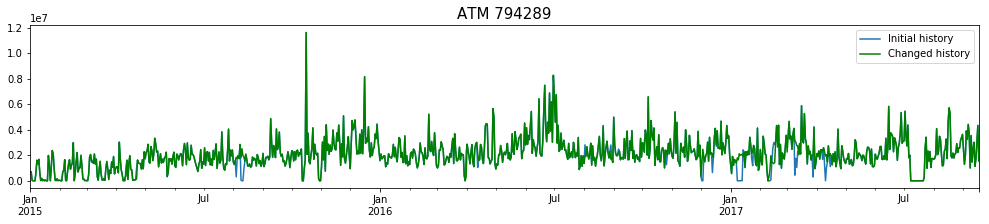

798105


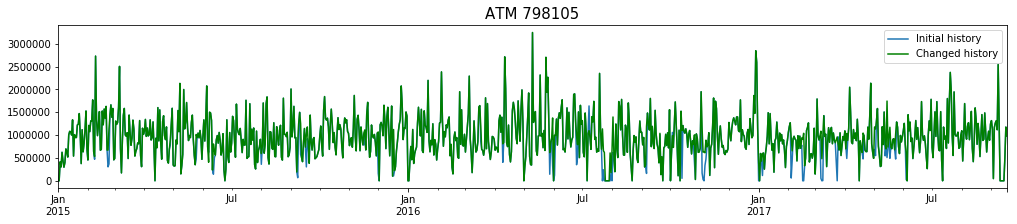

869273


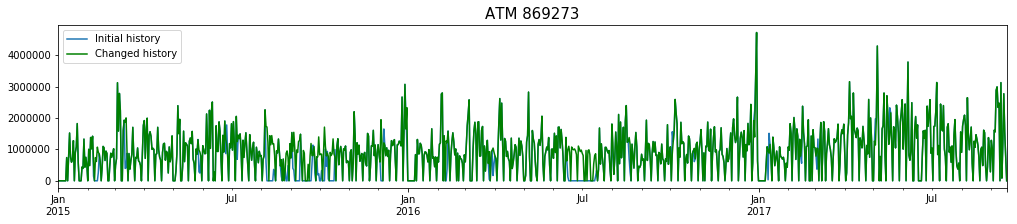

791711


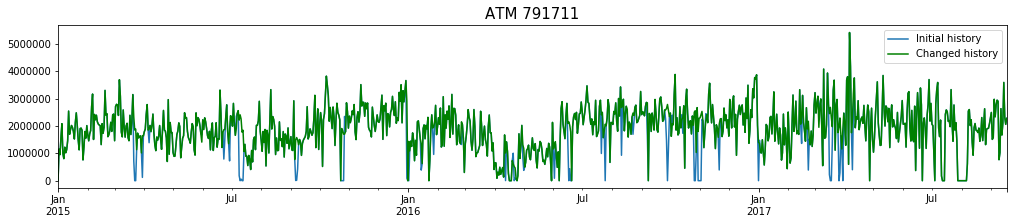

In [20]:
#Цикл по банкоматам для формирования пула ХФИ 
ids_to_process = set(subpool) - set(pool_processed.ATM_ID.unique())
hfi = pd.DataFrame()
for ID in ids_to_process:
    print(ID)
    timeSeries = smsb[smsb.ATM_ID == ID][target_col].copy()
    timeSeries.plot(figsize = (17, 3), label = 'Initial history')
    timeSeries_downtime = downtime[downtime.ATM_ID == ID].downtime
    processed_timeSeries = create_history_changed_ATM(ID, timeSeries, timeSeries_downtime, pool_processed, \
                                                      df_places, df_availability, events, target_col = 'CLIENT_OUT')
    processed_timeSeries['ATM_ID'] = [ID for i in range(len(processed_timeSeries))]
    processed_timeSeries = processed_timeSeries[['ATM_ID', target_col]]
    processed_timeSeries[target_col].plot(figsize = (17, 3), label = 'Changed history', color = 'green')
    plt.title('ATM '+ str(ID), size = 15)
    plt.legend()
    plt.show()
    hfi = pd.concat([hfi, processed_timeSeries])
    
hfi = hfi.append(pool_processed)

## 2. AnomalyDetector (на основе CUSUM)

Задаемся несколькими параметрами (которые можно обучать и/или адаптировать глазами под текущий временной ряд): 
- $a > 0$
- $A > 0$, $A > a$
- $w_{backward}$ - длина окна, на которое смотрим назад
- $w_{forward}$ - длина окна, на которое смотрим вперед

Обычно полагают $a = 1$, $A = 5$.

Пусть $\mu$ - среднее ряда, $\sigma$ - стандартное отклонение ряда, посчитанные в окне длиной $w_{backward}$ от текущего момента, $k = a \cdot \sigma$, $H = A \cdot \sigma$.

Строим верхний и нижний коридоры, которые задаются следующими рекуррентными формулами:

- верхний коридор или high sum: $S_{i}^{+} =\max\{0,S_{i−1}^{+} + x_i − μ − k\}$, $i = 1, \ldots, N$; $S_0^{+} = 0$; 
- нижний коридор или low sum: $S_{i}^{-} =\min\{0,S_{i−1}^{-} + x_i − μ + k\}$, $i = 1, \ldots, N$; $S_0^{-} = 0$; 

Свойства: 

- $S_{i}^{+} > S_{i-1}^{+}$ только если $x_i > \mu + k$;
- $S_{i}^{-} < S_{i-1}^{-}$ только если $x_i < \mu - k$.

То есть мы не обращаем внимания на колебания нашего ряда в пределах $[\mu-k, \mu+k]$.

Как решаем, когда случилась аномалия:

**в i-тый момент времени случилась аномалия тогда и только тогда, когда $S_{i}^{+} > H$ или $S_{i}^{-} < -H$**

Так как мы исследуем снятие наличных в банкоматах (значения этого ряда неотрицательны), то достаточно следить только за $S_i^{+}$.

<center>

<img src='./img/cusum.jpg' width='600'>
<img src='./img/cusum2.jpg' width='600'>

Статья: https://www.measurementlab.net/publications/CUSUMAnomalyDetection.pdf

In [21]:
import OstrovPackPrediction
import imp
imp.reload(OstrovPackPrediction)
from OstrovPackPrediction import AnomalyDetector, OstrovPredictor
from OstrovPackPrediction import *
import calendar

In [22]:
def plot_double(pred, true, roll_days=30):
    
    mae=np.abs(true-pred).shift(1).rolling(roll_days).mean().dropna()
    with plt.style.context('seaborn-white'):
        font = {'family': 'normal','weight': 'bold'}
        matplotlib.rc('font', **font)
        plt.figure(figsize=(17, 12))
        plt.subplots_adjust(wspace=0, hspace=0.4)
        gs = gridspec.GridSpec(5, 1)
        ax1 = plt.subplot(gs[:2, :])
        ax2 = plt.subplot(gs[2, :], sharex=ax1) 
        ax1.plot(pred/1e3, label='Prediction ')
        ax1.plot(true/1e3, label='Actual', color='r')
        ax2.plot(mae, color='#443f3e', label='MAE')
        ax2.set_title('MAE скользящее за {} дней '.format(roll_days), fontweight="bold")
        ax1.set_ylabel('тысяч рублей')
        #    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")


        ax1.legend()
        ax2.legend()
        ax1.grid(True)
        ax2.grid(True)
        plt.show()

In [23]:
all_data=pd.read_csv('./data/lecture2/atm_data_train.csv')
all_data=all_data.set_index('Unnamed: 0')
all_data.index=pd.to_datetime(all_data.index)

In [24]:
data=all_data[all_data.ATM_ID==409605]['Клиентский расход']

In [25]:
data=data.rename('y')

In [26]:
places=pd.read_csv('./data/lecture2/places.csv')
del places['Unnamed: 0']

Посмотим на наш исходный ряд. Заметны периодические пики, потому что это  - типичный зарплатный банкомат, находящийся в офисах или гос.учереждениях. Анализ детектором аномалий это подтверждает.

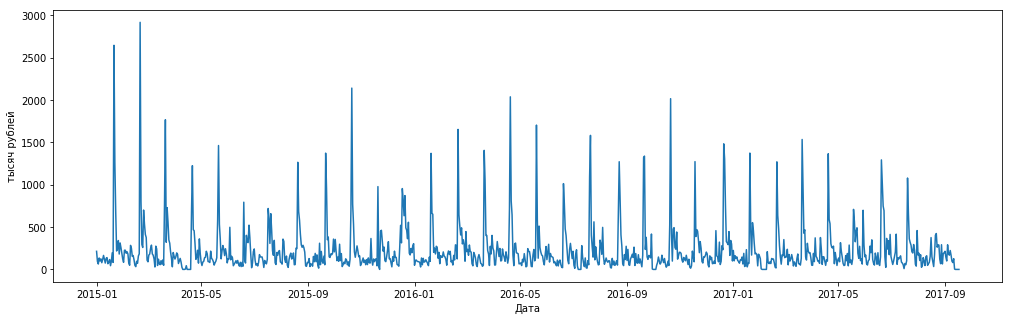

In [27]:
plt.figure(figsize=(17,5))
plt.plot(data/1e3)
plt.ylabel('тысяч рублей')
plt.xlabel('Дата')
plt.show()

In [28]:
AnomalyDetector??

In [29]:
detector = AnomalyDetector(backward_window_size=10, forward_window_size=2)
detector.detect(data)

Unnamed: 0
2015-01-01    0
2015-01-02    0
2015-01-03    0
2015-01-04    0
2015-01-05    0
             ..
2017-09-13    0
2017-09-14    0
2017-09-15    0
2017-09-16    0
2017-09-17    0
Length: 991, dtype: int32

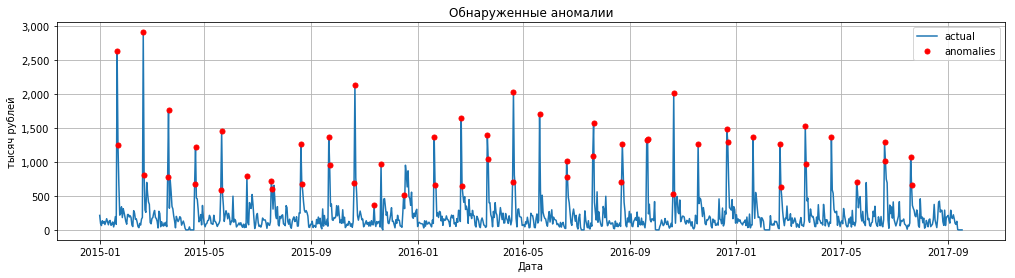

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(17, 4))
plt.subplots_adjust(wspace=0.1)
detector.plot(data / 1000, ax=ax, title='Обнаруженные аномалии')
plt.show()

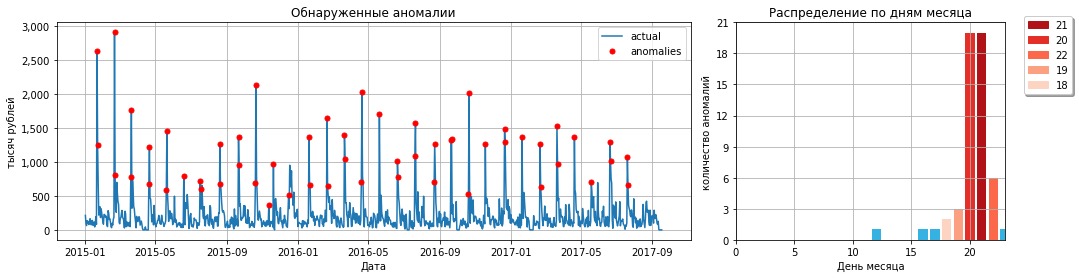

In [31]:
detector = AnomalyDetector(backward_window_size=10, forward_window_size=2)
detector.detect(data)
fig, axs = plt.subplots(1, 2, figsize=(17, 4), gridspec_kw={'width_ratios':[4, 1.7]})
plt.subplots_adjust(wspace=0.1)
detector.plot(data / 1000, ax=axs[0], title='Обнаруженные аномалии')
detector.hist(th=0.02, ax=axs[1], title='Распределение по дням месяца')
plt.show()

Вот еще несколько типичных зарплатных банкоматов.

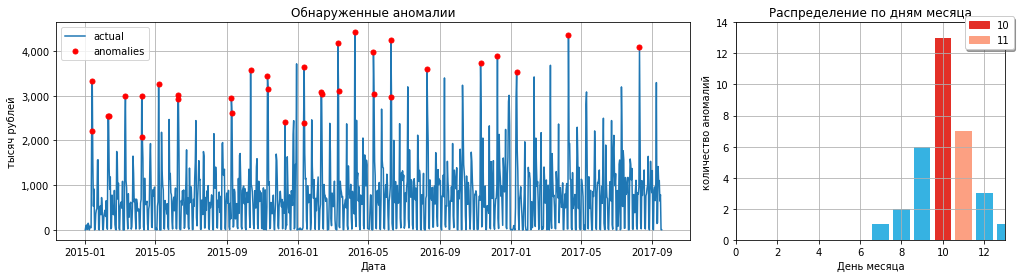

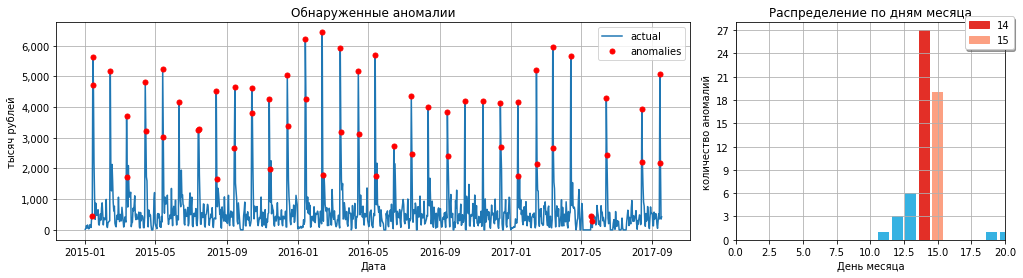

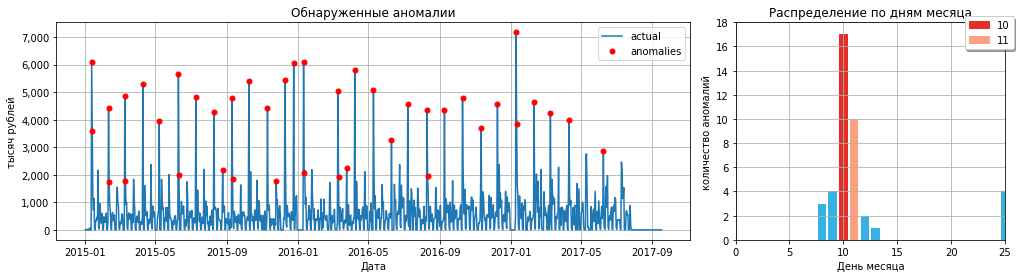

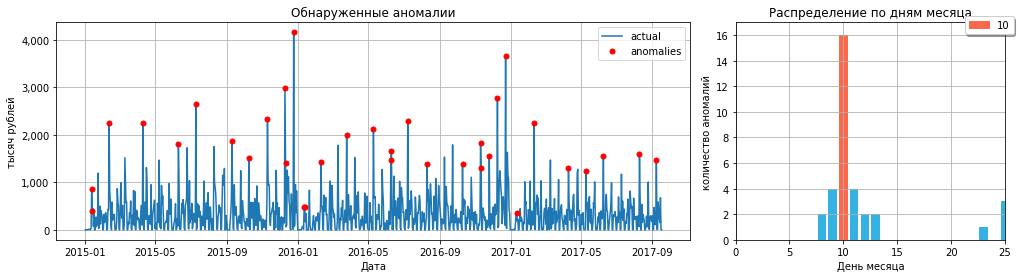

In [32]:
for atm_id in [650019,543453,827439,848704]:
    detector = AnomalyDetector(backward_window_size=10, forward_window_size=2)
    detector.detect(all_data[all_data.ATM_ID==atm_id]['Клиентский расход'])
    fig, axs = plt.subplots(1, 2, figsize=(17, 4), gridspec_kw={'width_ratios':[4, 1.7]})
    plt.subplots_adjust(wspace=0.1)
    detector.plot(all_data[all_data.ATM_ID==atm_id]['Клиентский расход'] / 1000, ax=axs[0], title='Обнаруженные аномалии', xlabel='Дата', ylabel='тысяч рублей')
    detector.hist(th=0.2, ax=axs[1], title='Распределение по дням месяца')
    plt.show()

А этот банкомат находится в торговом центре. Периодичных аномалий тут практически не заметно.

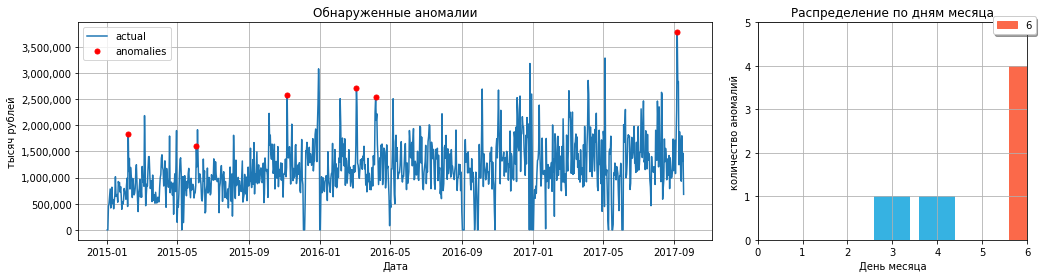

In [33]:
i=236860
detector = AnomalyDetector(backward_window_size=10, forward_window_size=2)
detector.detect(all_data[all_data.ATM_ID==i]['Клиентский расход'])
fig, axs = plt.subplots(1, 2, figsize=(17, 4), gridspec_kw={'width_ratios':[4, 1.7]})
plt.subplots_adjust(wspace=0.1)
detector.plot(all_data[all_data.ATM_ID==i]['Клиентский расход'], ax=axs[0], title='Обнаруженные аномалии')
detector.hist(th=0.2, ax=axs[1], title='Распределение по дням месяца')
plt.show()

##### Подбор лагов.

Лаги - это значения временного ряда за предыдущие дни. Рассмотрим их влияние, для этого построим графики корреляций для лагов до 50го.

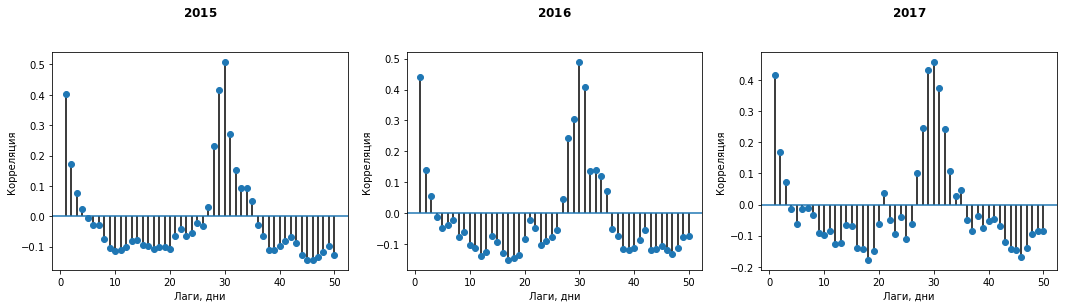

In [34]:
nlags = 50
dm = '-01-01'

date_range = [('2015', '2016'), 
              ('2016', '2017'), ('2017', '2018')]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
axs=axs.ravel()
plt.subplots_adjust(hspace=0.4)
for j, (s,e) in enumerate(date_range):
    data_cut = data[str(s)+dm:str(e)+dm].copy()
    r = []
    for n in range(1, nlags+1):
        r_current = np.corrcoef(data_cut[n:], data_cut.shift(n)[n:])[0, 1]
        r.append(r_current)
        
    axs[j].vlines(range(1, nlags+1), [0], r)
    axs[j].axhline()
    axs[j].plot(range(1, nlags+1), r, 'o')
    axs[j].set_title(r"$\bf{" + str(s) + "}$" + "\n"*2)
    axs[j].set_xlabel('Лаги, дни')   
    axs[j].set_ylabel('Корреляция')
plt.show()

В нашем классе для предсказаний используется функция, которая автоматически выбирает значимые лаги и заносит их в признаковое постанство.

##### Анализ сезонности. Тепловая карта.

Для изучение сезонности внутри каждого месяца построим heat map за каждый год (по оси X - дни месяца, по оси Y - месяца). Чем холоднее цвет (синее), тем меньшие суммы обычно проходят в этот день, чем теплее (краснее) - тем большая сумма. Нормирование значений (min-max) происходит в рамках каждого месяца.

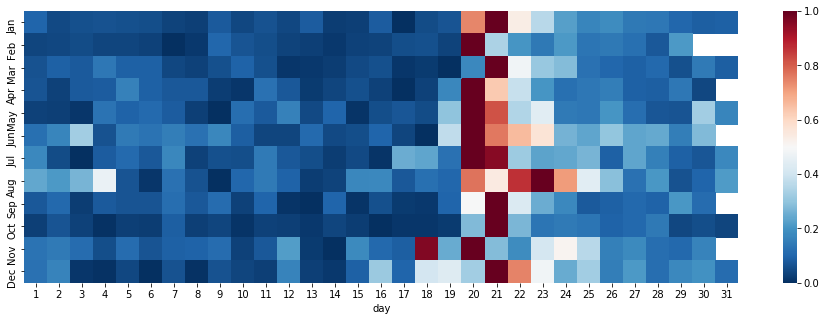

In [35]:
def minmax(x):
    q = x - np.nanmin(x)
    r = np.nanmax(x) - np.nanmin(x)
    return q / r
data_heat=data.copy()
data_heat = data_heat.groupby([data_heat.index.month, data_heat.index.day]).mean()
data_heat.index.names = ['month', 'day']
data_heat=data_heat.reset_index()

data_heat_t=data_heat.copy()
data_heat['y'] = data_heat['y'].groupby(data_heat['month']).transform(lambda x: minmax(x))
data_heat = data_heat.pivot('month', 'day')
data_heat=data_heat['y']
data_heat.index = [calendar.month_abbr[x] for x in data_heat.index]

fig, axs = plt.subplots(figsize=(16, 5))
sns.heatmap(data_heat, cmap="RdBu_r")
plt.show()

Выглядит странно, не правда ли? Возможно, стоит сначала очистить ряд от периодичных аномалий.

In [36]:
detector = AnomalyDetectorDaily(backward_window_size=10, forward_window_size=2)
_=detector.detect(data)
anom1=detector.anomalies_
data2=data[~data.index.isin(anom1[anom1==1].index)]

detector2 = AnomalyDetectorDaily(backward_window_size=10, forward_window_size=2)
_=detector2.detect(data2)
anom2=detector2.anomalies_
data3=data2[~data2.index.isin(anom2[anom2==1].index)]

detector3 = AnomalyDetectorDaily(backward_window_size=10, forward_window_size=2)
_=detector3.detect(data3)
anom3=detector3.anomalies_
data4=data3[~data3.index.isin(anom3[anom3==1].index)]

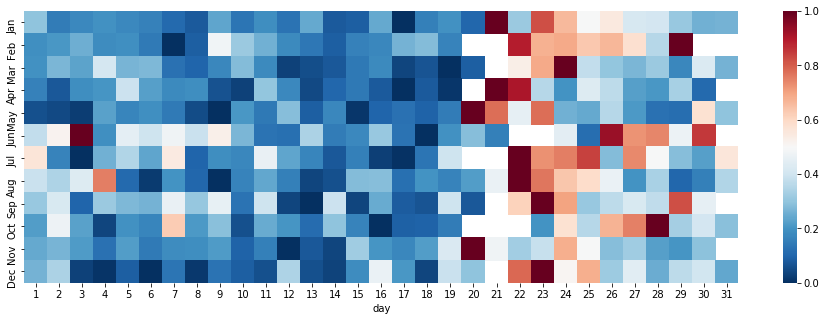

In [37]:
def minmax(x):
    q = x - np.nanmin(x)
    r = np.nanmax(x) - np.nanmin(x)
    return q / r
data_heat=data4.copy()
data_heat = data_heat.groupby([data_heat.index.month, data_heat.index.day]).mean()
data_heat.index.names = ['month', 'day']
data_heat=data_heat.reset_index()

data_heat_t=data_heat.copy()
data_heat['y'] = data_heat['y'].groupby(data_heat['month']).transform(lambda x: minmax(x))
data_heat = data_heat.pivot('month', 'day')
data_heat=data_heat['y']
data_heat.index = [calendar.month_abbr[x] for x in data_heat.index]

fig, axs = plt.subplots(figsize=(16, 5))
#fig.suptitle("Тип: {}".format(t), fontsize=18)
sns.heatmap(data_heat, cmap="RdBu_r")
plt.show()

Даже очистив ряд от периодичных аномалий(зарплатные дни), мы видим, что основные снятия происходят в третьей декаде месяце. Это заметно и на основном графике ряда - снижение после пиковых значений не резкое, а постепенное.

##### Добавим календарные признаки:
* день недели
* месяц
* квартал
* выходной
* праздник
* сокращенный рабочий день

Часть из этих признаков (неделя, месяц,квартал) мы закодируем с помощью one-hot encoding, так как они имеют категориальную природу.

In [38]:
data.index.weekday

Int64Index([3, 4, 5, 6, 0, 1, 2, 3, 4, 5,
            ...
            4, 5, 6, 0, 1, 2, 3, 4, 5, 6],
           dtype='int64', name='Unnamed: 0', length=991)

In [39]:
weekday=pd.get_dummies(data.index.weekday,prefix='weekday').set_index(data.index)
weekday.head()

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
Unnamed: 0,,,,,,,
2015-01-01,0,0,0,1,0,0,0
2015-01-02,0,0,0,0,1,0,0
2015-01-03,0,0,0,0,0,1,0
2015-01-04,0,0,0,0,0,0,1
2015-01-05,1,0,0,0,0,0,0


In [40]:
month=pd.get_dummies(data.index.month,prefix='month').set_index(data.index)
month.head()

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
Unnamed: 0,,,,,,,,,,,,
2015-01-01,1,0,0,0,0,0,0,0,0,0,0,0
2015-01-02,1,0,0,0,0,0,0,0,0,0,0,0
2015-01-03,1,0,0,0,0,0,0,0,0,0,0,0
2015-01-04,1,0,0,0,0,0,0,0,0,0,0,0
2015-01-05,1,0,0,0,0,0,0,0,0,0,0,0


In [41]:
quarter=pd.get_dummies(data.index.quarter,prefix='quarter').set_index(data.index)
quarter.head()

,quarter_1,quarter_2,quarter_3,quarter_4
Unnamed: 0,,,,
2015-01-01,1,0,0,0
2015-01-02,1,0,0,0
2015-01-03,1,0,0,0
2015-01-04,1,0,0,0
2015-01-05,1,0,0,0


Соберем наши календарные признаки в один датафрейм - наше общее признаковое пространство.

In [42]:
features_df=pd.concat([weekday,month,quarter],axis=1)

##### Добавим скользящие статистики:
* mean
* median
* std
* max
* min

Это стандартный набор статистик, скользящее значение по которым (значение в окне определенного размера - предыдущие  2 дня, неделя, месяц) мы добавим в качестве дополнительных фичей.

In [43]:
rolling=data.rolling(7).agg(['mean','std','median','max','min']).shift(1)
rolling.dropna().head()

,mean,std,median,max,min
Unnamed: 0,,,,,
2015-01-08,115700.000000,49549.806592,99800.0,213400.0,63900.0
2015-01-09,102057.142857,25455.049083,99800.0,134900.0,63900.0
2015-01-10,112128.571429,34356.984457,117900.0,165000.0,63900.0
2015-01-11,119985.714286,26988.048501,118900.0,165000.0,78900.0
2015-01-12,111442.857143,30690.816061,117900.0,165000.0,75100.0


In [44]:
features_df=pd.concat([features_df,rolling],axis=1)

##### Добавим разметку разметку зарплатных дней:

Для начала применим AnomalyDetector для определения аномальных дат, которые появляются с высокой частотой - зарпалтных дат.


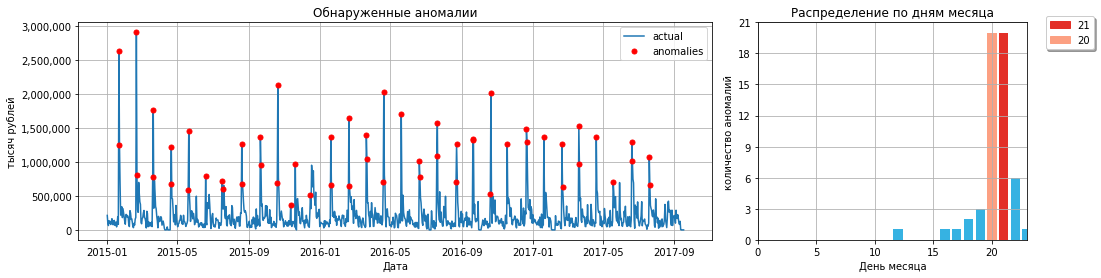

In [45]:
detector = AnomalyDetector(backward_window_size=10, forward_window_size=2)
detector.detect(data)
fig, axs = plt.subplots(1, 2, figsize=(17, 4), gridspec_kw={'width_ratios':[4, 1.7]})
plt.subplots_adjust(wspace=0.1)
detector.plot(data, ax=axs[0], title='Обнаруженные аномалии')
detector.hist(th=0.2, ax=axs[1], title='Распределение по дням месяца')
plt.show()

Так как во временном ряду могут присутствовать пики различной "силы", например, зарплата и аванс или выплаты разных предприятий, обнаруженные дни зарплат удаляются из рассмотрения и алгоритм запускается заново.

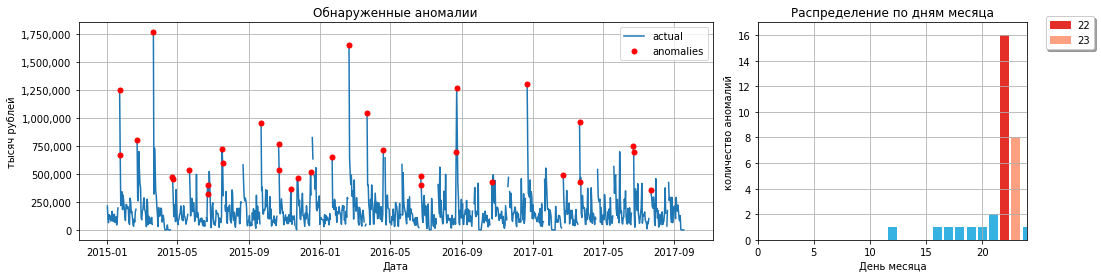

In [46]:
detector = AnomalyDetectorDaily(backward_window_size=10, forward_window_size=2)
detector.detect(data)
anom_20 = detector.mark_features(day=20, kind=-1)
anom_21 = detector.mark_features(day=21, kind=-1)
anom = anom_20 + anom_21
anom_index = anom[anom > 0].index
data_2it = data.copy()
data_2it[data_2it.index.isin(anom_index)] = np.nan

detector = AnomalyDetector(backward_window_size=10, forward_window_size=2)
detector.detect(data_2it)
fig, axs = plt.subplots(1, 2, figsize=(17, 4), gridspec_kw={'width_ratios':[4, 1.7]})
plt.subplots_adjust(wspace=0.1)
detector.plot(data_2it, ax=axs[0], title='Обнаруженные аномалии')
detector.hist(th=0.2, ax=axs[1], title='Распределение по дням месяца')
plt.show()

Добавим размеченные дни в качестве фичей.

In [47]:
detector = AnomalyDetectorDaily(backward_window_size=10, forward_window_size=2)
_=detector.detect(data)
features_df['20_число']=detector.mark_features(day=20,kind=-1)
features_df['21_число']=detector.mark_features(day=21,kind=-1)
features_df['22_число']=detector.mark_features(day=22,kind=-1)
features_df['23_число']=detector.mark_features(day=23,kind=-1)

Взглянем на наше общее признаковое пространство.

In [48]:
pd.set_option('display.max_columns',None)

In [49]:
features_df

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4,mean,std,median,max,min,20_число,21_число,22_число,23_число
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2015-01-02,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2015-01-03,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2015-01-04,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2015-01-05,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-13,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,123614.285714,71100.338222,126700.0,222800.0,4300.0,0,0,0,0
2017-09-14,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,99628.571429,81264.603083,97000.0,222800.0,0.0,0,0,0,0
2017-09-15,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,67800.000000,67437.452502,81000.0,165600.0,0.0,0,0,0,0


## Прогноз

Для начала, посмотрим на качество прогноза, предсказывая по 5 дней, и не используя дополнительного признакового пространства, а только лаги.

In [50]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

In [51]:
model_predictions={'GB':None}

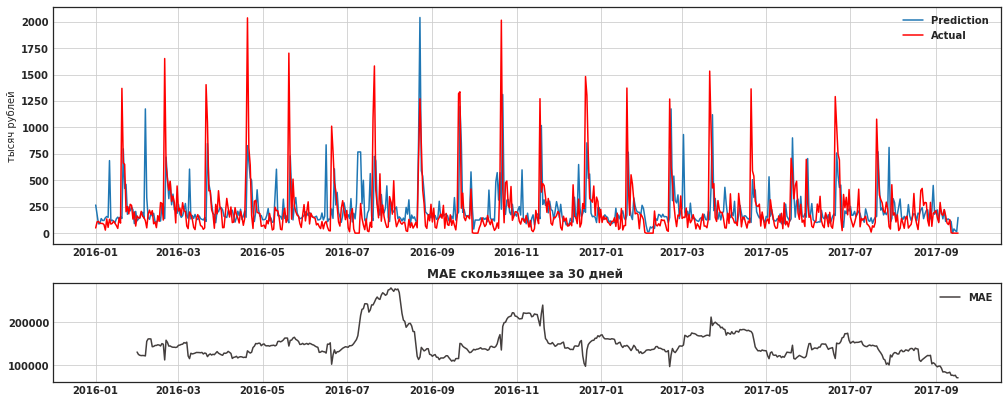

In [52]:
pred = OstrovPredictor(model=GradientBoostingRegressor(random_state=42),backward_window_size=365,\
              forward_window_size=5,add_features_table=None,auto_lags=True,get_features_importance=False)
y, yhat, _ = pred.predict(timeseries=data)
results = pd.DataFrame({'факт': y, 'прогноз':yhat})
plot_double(results['прогноз'],results['факт'])

In [53]:
mae = round(np.nanmean(np.abs(results['факт'] - results['прогноз'])), 2)
print("MAE : {}".format(mae))

MAE : 147773.3


Передадим нашу таблицу признаков параметру add_table.

In [54]:
model_predictions = dict()

In [55]:
features_df

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4,mean,std,median,max,min,20_число,21_число,22_число,23_число
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2015-01-02,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2015-01-03,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2015-01-04,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2015-01-05,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-13,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,123614.285714,71100.338222,126700.0,222800.0,4300.0,0,0,0,0
2017-09-14,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,99628.571429,81264.603083,97000.0,222800.0,0.0,0,0,0,0
2017-09-15,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,67800.000000,67437.452502,81000.0,165600.0,0.0,0,0,0,0


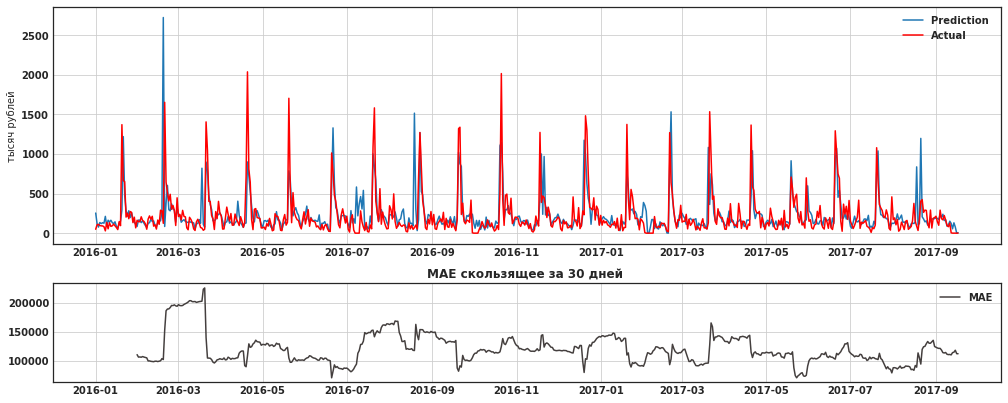

In [56]:
pred = OstrovPredictor(model=GradientBoostingRegressor(random_state=42),backward_window_size=365,\
              forward_window_size=5,add_features_table=features_df,auto_lags=True)
y, yhat,_ = pred.predict(timeseries=data)
results = pd.DataFrame({'факт': y, 'прогноз':yhat})
plot_double(results['прогноз'],results['факт'])
model_predictions['GB']=results

In [57]:
mae = round(np.nanmean(np.abs(results['факт'] - results['прогноз'])), 2)
print("MAE после добавления фичей: {}".format(mae))

MAE после добавления фичей: 118051.8


In [58]:
mae

118051.8

Посмотрим, какое качество показывают другие модели:
* LinearRegression
* RandomForestRegressor
* Lasso
* ElasticNet

MAE модели LR : 121146.38


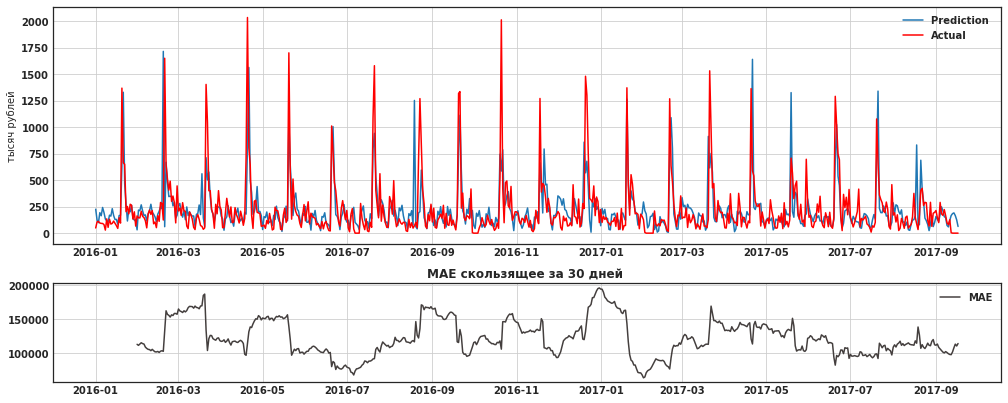

MAE модели LASSO : 136532.79


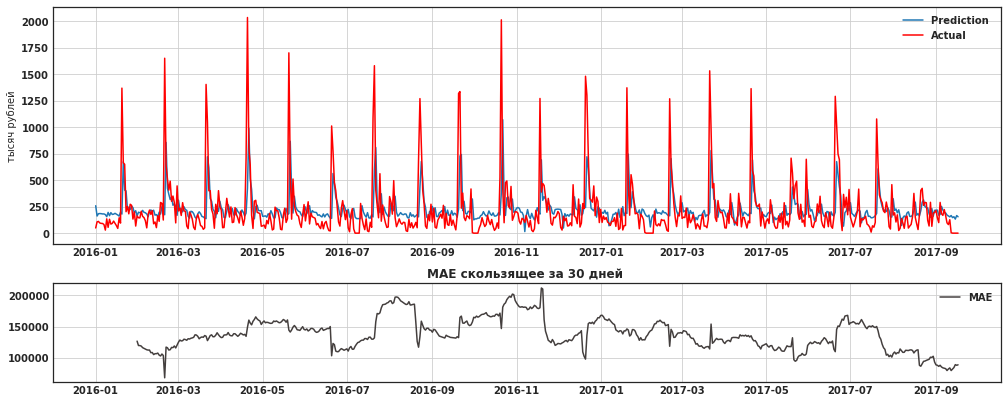

MAE модели ElasticNet : 133321.75


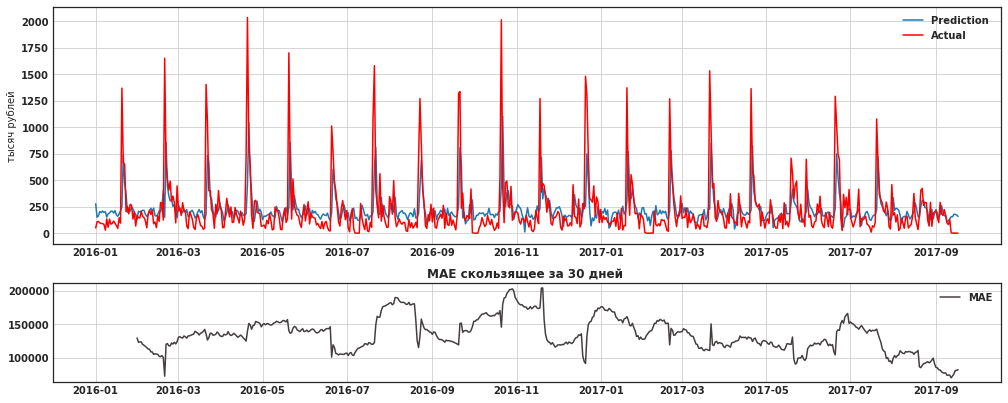

MAE модели RandomForest : 116371.69


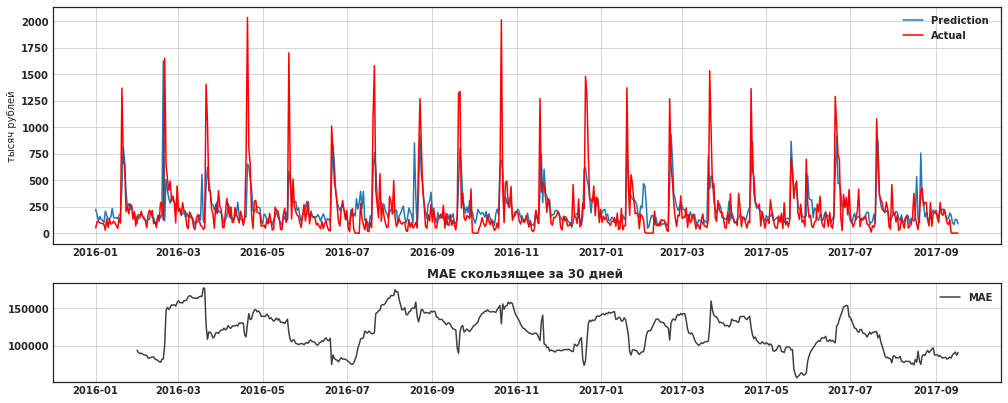

In [59]:
models = [LinearRegression(), Lasso(alpha = 1e9), ElasticNet(1, 0.5),
          RandomForestRegressor(n_estimators=100, max_features='sqrt', random_state=2)]
models_name = ['LR', 'LASSO', 'ElasticNet', 'RandomForest']
for i,k in zip(models,models_name):
    pred = OstrovPredictor(model=i,backward_window_size=365,\
              forward_window_size=5,add_features_table=features_df,auto_lags=True)
    y, yhat,_ = pred.predict(timeseries=data)
    results = pd.DataFrame({'факт': y, 'прогноз':yhat})
    mae = round(np.nanmean(np.abs(results['факт'] - results['прогноз'])), 2)
    print("MAE модели {} : {}".format(k,mae))
    plot_double(results['прогноз'],results['факт'])
    model_predictions[k]=results

Кстати в работе в качестве метрики мы зачастую используем **AUC_MAE@N** - (N - число дней рассматриваемого периода) - площадь под кривой TH-MAE за заданный промежуток времени. Позволяет гибко учитывать разные доверительные интервалы ошибки в зависимости от аппетита к риску. AUC_MAE - площадь под кривой, отражающей процент попадания в заданный корридор ошибки (чем больше площадь под кривой, тем лучше). Отчасти является аналогом $ROC\_AUC$ (но в заданном диапозоне ошибки).


Значение метрики AUC_MAE@N является относительной величиной в пределах от 0 до 100% и вычисляется следующим образом:
* определяется порог отсечения bound (в нашем случае - 150000 рублей)
* в прямоугольнике $[0, bound] \times [0, 100]$ вычисляется площадь под кривой AUC_MAE@N
* полученная площадь нормируется на площадь прямоугольника: $$area = \frac{under\_curve\_area}{bound} $$

In [60]:
def confidence_bands(series):
    n_days=len(series)
    intervals=np.linspace(0,15e4,1001)
    ths=list()
    for interval in intervals:
        k=0
        for d in range(n_days):
            if np.abs(series[d])<interval:
                k+=1
        ths.append(k/n_days*100)
    area=0
    for q in ths[1:]:
        area+=q*150
    return [intervals,ths],area/(100*15e4)*100

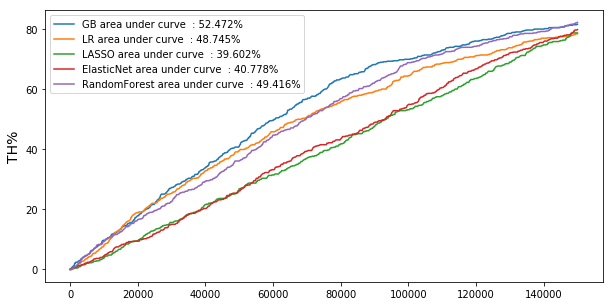

In [61]:
fig, axes = plt.subplots(figsize=(10,5))
for i in model_predictions:
    coordinates,area=confidence_bands(model_predictions[i]['факт']-model_predictions[i]['прогноз'])
    axes.plot(coordinates[0],coordinates[1],label=i+' area under curve  : '+str(round(area,3))+'%')
    axes.set_ylabel('TH%',fontsize=14)
    axes.legend()
plt.show()

Было бы весьма интересно посмотреть, какие фичи наш алгоитм считает важными. Выведем для этого столбчатую диаграмму feature_importances, усредненную по дням.

In [62]:
feat_names=sum([['лаг1','лаг2'],list(features_df.columns)],[])

In [63]:
pred = OstrovPredictor(model=GradientBoostingRegressor(random_state=42),backward_window_size=365,\
              forward_window_size=5,add_features_table=features_df,auto_lags=True,get_features_importance=True)
y, yhat, feat_importances = pred.predict(timeseries=data)

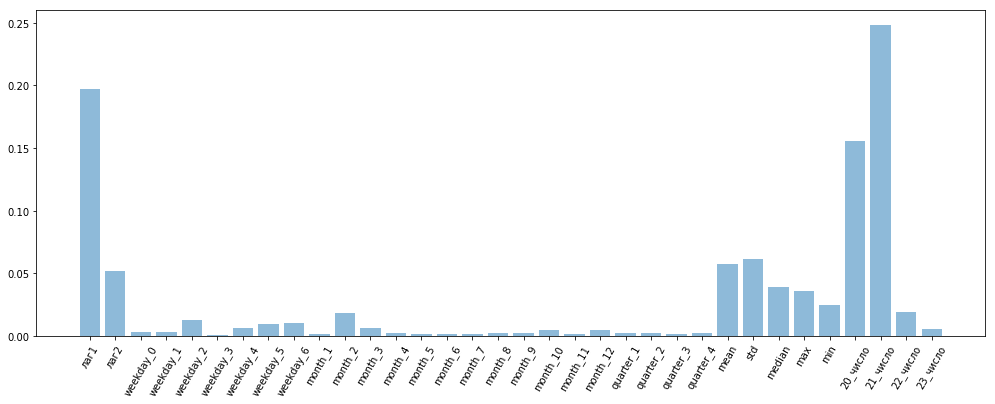

In [64]:
plt.figure(figsize=(17,6))
pos=np.arange(len(np.array(feat_importances).mean(axis=0)))
plt.bar(pos,np.array(feat_importances).mean(axis=0),alpha=0.5)
plt.xticks(pos,feat_names,rotation=60)
plt.show()

Очень хорошая статья про градиентный бустинг: https://habr.com/ru/company/ods/blog/327250/